In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [3]:
df = pd.read_csv('new_retail_data.csv')

print(df.info())
print(df.describe())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    301677 non-null  float64
 1   Customer_ID       301702 non-null  float64
 2   Name              301628 non-null  object 
 3   Email             301663 non-null  object 
 4   Phone             301648 non-null  float64
 5   Address           301695 non-null  object 
 6   City              301762 non-null  object 
 7   State             301729 non-null  object 
 8   Zipcode           301670 non-null  float64
 9   Country           301739 non-null  object 
 10  Age               301837 non-null  float64
 11  Gender            301693 non-null  object 
 12  Income            301720 non-null  object 
 13  Customer_Segment  301795 non-null  object 
 14  Date              301651 non-null  object 
 15  Year              301660 non-null  float64
 16  Month             30

In [4]:
print(df['products'].unique())

print(df['Product_Brand'].unique())

print(df['Product_Category'].unique())

print(df['Customer_Segment'].unique())

['Cycling shorts' 'Lenovo Tab' 'Sports equipment' 'Utility knife'
 'Chocolate cookies' 'QLED TV' 'Dress shirt' 'Dark chocolate' 'Candles'
 'Screwdriver set' 'Science' 'Bottled water' 'Fruit snacks' 'V-neck tee'
 'Drama' 'Flavored water' 'Samsung Galaxy Tab' 'Orange juice' 'Bookshelf'
 'Affogato' 'Business' 'Self-help' 'Sink' 'Grape juice' 'Stove' 'Huawei P'
 'Amazon Fire Tablet' 'Curtains' 'Pomegranate juice' 'Running shoes'
 'Political thriller' 'Google Pixel' 'Chocolate mousse' 'Vases'
 'Henley shirt' 'Toys' 'Iced tea' 'Apple juice' 'Microsoft Surface Laptop'
 'Desk' 'Bodycon dress' 'Sports headphones' 'Pendant lights' 'Clocks'
 'Comforter' 'Peacoat' 'Bed' 'White chocolate' 'Android TV'
 'Studio headphones' 'Sneakers' 'Sculptures' 'Cream soda' 'History'
 'Pliers' 'Oxfords' 'Short stories' 'Dining table' 'Cooking' 'Wall art'
 'Memoir' 'Maxi dress' 'LG Gram' 'Dishwasher' 'Cranberry juice' 'Crime'
 'Pillowcase set' 'Shower curtain' 'Samsung Galaxy' 'Curved TV'
 'DJ headphones' 'Button-d

UNDERSTAND THE TOTAL AMOUNTS PE

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


#Normalize Categorical Columns
for c in ['products', 'Product_Brand', 'Product_Category', 'Product_Type']:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()


#normalize numerical columns
for c in['Amount', 'Total_Amount', 'Quantity', 'Total_Purchase']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

amount = df.get('Amount')
qty = df.get('Quantity')
total = df.get('Total_Amount')

# Initialize sales as NaN
df['sales'] = np.nan

# Safely assign sales based on existing columns
if total is not None:
    df['sales'] = total
elif qty is not None and amount is not None:
    df['sales'] = qty * amount
elif amount is not None:
    df['sales'] = amount

df['YearMonth'] = df['Date'].dt.to_period('M').dt.to_timestamp()

print(df[['Date','YearMonth','Product_Brand','Product_Category','Product_Type','products','Amount','Total_Amount','sales']].head())
print(df['sales'].describe())

        Date  YearMonth  Product_Brand Product_Category Product_Type  \
0 2023-09-18 2023-09-01           nike         clothing       shorts   
1 2023-12-31 2023-12-01        samsung      electronics       tablet   
2 2023-04-26 2023-04-01  penguin books            books   children's   
3 2023-05-08 2023-05-01     home depot       home decor        tools   
4 2024-01-10 2024-01-01         nestle          grocery    chocolate   

            products      Amount  Total_Amount        sales  
0     cycling shorts  108.028757    324.086270   324.086270  
1         lenovo tab  403.353907    806.707815   806.707815  
2   sports equipment  354.477600   1063.432799  1063.432799  
3      utility knife  352.407717   2466.854021  2466.854021  
4  chocolate cookies  124.276524    248.553049   248.553049  
count    301660.000000
mean       1367.651156
std        1128.998515
min          10.003750
25%         438.724278
50%        1041.117547
75%        2029.999853
max        4999.625796
Name: sales

,Product_Brand,products,total_sales
18,adidas,plain tee,936712.277294
11,adidas,leather jacket,910768.696676
17,adidas,peacoat,909531.386805
22,adidas,sandals,906944.049082
3,adidas,crew neck tee,880326.162239
23,adidas,scoop neck tee,878585.221436
7,adidas,flip flops,877734.339878
9,adidas,henley tee,870871.846588
15,adidas,oxfords,866343.528429
13,adidas,long-sleeve tee,861201.980149


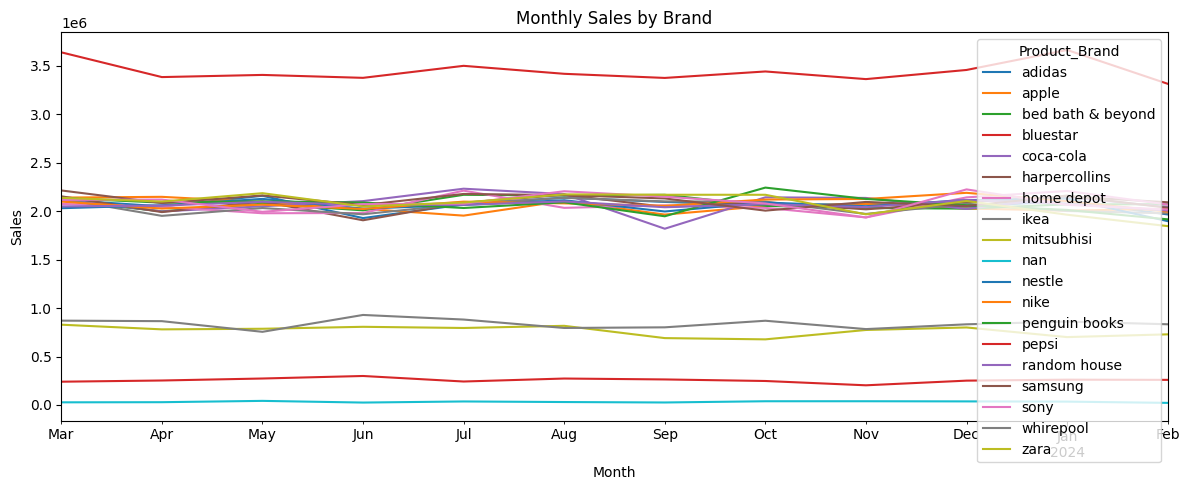

In [6]:
agg_cols = ['YearMonth', 'Product_Brand', 'Product_Category', 'Product_Type', 'products']

monthly = (df.dropna(subset=['YearMonth', 'sales']).groupby(agg_cols, dropna=False).agg(total_sales=('sales', 'sum'),
                                                                                        orders=('Transaction_ID', 'nunique'),
                                                                                        total_purchase=('Total_Purchases', 'sum')).reset_index())

top = (monthly.groupby(['Product_Brand', 'products'], as_index=False)['total_sales'].sum().sort_values(['Product_Brand', 'total_sales'], ascending=[True, False]))
display(top.head(20))


sample = monthly[monthly['Product_Brand'].notna()].groupby(['YearMonth','Product_Brand'])['total_sales'].sum().reset_index()
pivot_sample = sample.pivot(index='YearMonth', columns='Product_Brand', values='total_sales').fillna(0)
pivot_sample.plot(figsize=(12,5), title='Monthly Sales by Brand'); plt.ylabel('Sales'); plt.xlabel('Month'); plt.tight_layout(); plt.show()

BUILD MACHINE LEARNING DATASE TO PREDICT MONTHLY SALES PER BRAND AND PRODUCTY TYPE
- also adds lag features
- add seaonsal features

In [11]:
brand_type = (df.dropna(subset=['YearMonth', 'sales', 'Product_Brand', 'Product_Type'])
            .groupby(['YearMonth', 'Product_Brand', 'Product_Type', ])['sales']
            .sum().reset_index().rename(columns={'sales':'total_sales'}))
            
min_m, max_m = brand_type['YearMonth'].min(), brand_type['YearMonth'].max()

print(f"brand_type shape: {brand_type.shape}")
print(brand_type.head())
print(brand_type.columns)


def complete_group(g):
    idx = pd.date_range(min_m, max_m, freq='MS')
    brand = g['Product_Brand'].iloc[0]
    ptype = g['Product_Type'].iloc[0]
    
    g = g.set_index('YearMonth')[['total_sales']].reindex(idx, fill_value=0.0).rename_axis('YearMonth').reset_index()
    
    g['Product_Brand'] = brand
    g['Product_Type'] = ptype

    return g


brand_type_complete = (brand_type.groupby(['Product_Brand', 'Product_Type'], group_keys=False).apply(complete_group).reset_index(drop=True))

def add_lags(g):
    for i in [1,2,3]:
        g[f'lag_{i}'] = g['total_sales'].shift(i)
    g['roll3'] = g['total_sales'].rolling(3).mean()
    g['roll6'] = g['total_sales'].rolling(6).mean()
    return g

brand_type_complete = (brand_type_complete.sort_values(['Product_Brand', 'Product_Type', 'YearMonth']).groupby(['Product_Brand', 'Product_Type'], group_keys=False).apply(add_lags))

brand_type_complete['month'] = brand_type_complete['YearMonth'].dt.month
brand_type_complete['m_sin'] = np.sin(2 * np.pi * brand_type_complete['month']/ 12)
brand_type_complete['m_cos'] = np.cos(2 * np.pi * brand_type_complete['month']/ 12)

brand_type_complete['brand_code'] = brand_type_complete['Product_Brand'].astype('category').cat.codes
brand_type_complete['type_code'] = brand_type_complete['Product_Type'].astype('category').cat.codes

bt_ml = brand_type_complete.dropna(subset=['lag_1', 'lag_2', 'lag_3']).copy()
print(bt_ml.head(10))

brand_type shape: (764, 4)
   YearMonth Product_Brand Product_Type    total_sales
0 2023-03-01        adidas       jacket  666980.744595
1 2023-03-01        adidas        shoes  719605.684414
2 2023-03-01        adidas      t-shirt  730544.803573
3 2023-03-01         apple       laptop  772888.228973
4 2023-03-01         apple   smartphone  652246.517537
Index(['YearMonth', 'Product_Brand', 'Product_Type', 'total_sales'], dtype='object')
    YearMonth    total_sales Product_Brand Product_Type          lag_1  \
3  2023-06-01  637049.631651        adidas       jacket  695324.388213   
4  2023-07-01  667437.502503        adidas       jacket  637049.631651   
5  2023-08-01  684015.444547        adidas       jacket  667437.502503   
6  2023-09-01  689879.413004        adidas       jacket  684015.444547   
7  2023-10-01  693117.305755        adidas       jacket  689879.413004   
8  2023-11-01  645942.630478        adidas       jacket  693117.305755   
9  2023-12-01  704048.052651        adid

C:\Users\ren42\AppData\Local\Temp\ipykernel_15172\3720452135.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  brand_type_complete = (brand_type.groupby(['Product_Brand', 'Product_Type'], group_keys=False).apply(complete_group).reset_index(drop=True))
C:\Users\ren42\AppData\Local\Temp\ipykernel_15172\3720452135.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  brand_type_complete = (brand_type_complete.sort_val